In [39]:
#Solving a time series problem using xg boost algorithm

In [40]:
#Importing all the necessary libraries and packages

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from xgboost import plot_importance
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import TimeSeriesSplit
from datetime import datetime

In [3]:
# Giving path of the file

In [13]:
PATH_TRAINING = r"C:\Users\VETERAN\Downloads\train_IxoE5JN.csv"

In [14]:
df = pd.read_csv(PATH_TRAINING, parse_dates = ['datetime'])
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94992 entries, 0 to 94991
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   row_id    94992 non-null  int64         
 1   datetime  94992 non-null  datetime64[ns]
 2   energy    93092 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 2.2 MB
None


In [46]:
#Info of the dataset tells that we have in total 94992 entries for test dataset and we can clearly see energy column has some null values

In [16]:
df.describe()

,row_id,energy
count,94992.000000,93092.000000
mean,47496.500000,1702.995014
std,27421.972723,369.322103
min,1.000000,866.388600
25%,23748.750000,1431.541100
50%,47496.500000,1654.465800
75%,71244.250000,1935.993450
max,94992.000000,3374.399600


In [48]:
#So we can see all statistical properties of energy column in above table
#75% energy values are below 2000

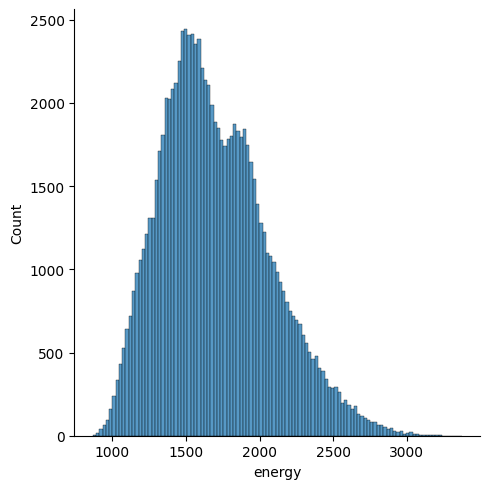

In [17]:
sns.displot(df["energy"])

In [50]:
#Plot of energy shows this graph above which is not normally distributed so it can cause a problem for regression algorithm

In [51]:
#Making box plot to check for outliers

<AxesSubplot:xlabel='energy'>

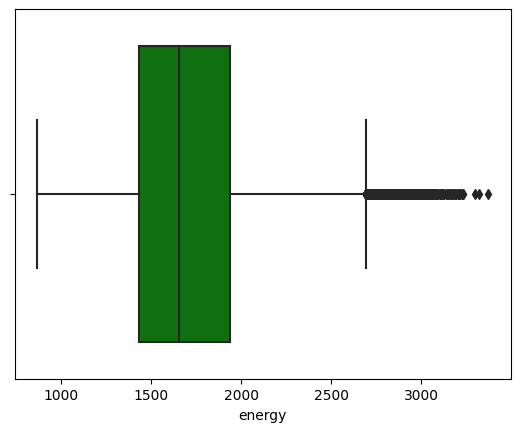

In [18]:
sns.boxplot(x= df["energy"], color="green")

In [53]:
#As we can see outliers are after range 2700 but we will not remove it until we get to understand the reason behind these outliers

In [54]:
#logging the target variable so that it will be bit normally distributed which will lead us to better results while using regression algorithms

In [19]:
df["log_energy"] = np.log(df["energy"])
df = df[["datetime", "log_energy"]]
display(df)

,datetime,log_energy
0,2008-03-01 00:00:00,7.138856
1,2008-03-01 01:00:00,6.999004
2,2008-03-01 02:00:00,6.962478
3,2008-03-01 03:00:00,6.941907
4,2008-03-01 04:00:00,6.933749
...,...,...
94987,2018-12-31 19:00:00,7.835360
94988,2018-12-31 20:00:00,7.808682
94989,2018-12-31 21:00:00,7.768954
94990,2018-12-31 22:00:00,7.759163


In [20]:
#Checking for null values again to get a clear picture
#Number of null values in all columns
df.isnull().sum().sort_values(ascending = True)

datetime         0
log_energy    1900
dtype: int64

In [57]:
#Checking the percentage of data retained if we use dropna() method

In [22]:
len(df["log_energy"].dropna())/len(df)

0.9799983156476335

In [59]:
#As almost 97% data will be retained therefore we will use dropna

In [23]:
df = df.dropna()
df.shape

(93092, 2)

In [24]:
display(df)

,datetime,log_energy
0,2008-03-01 00:00:00,7.138856
1,2008-03-01 01:00:00,6.999004
2,2008-03-01 02:00:00,6.962478
3,2008-03-01 03:00:00,6.941907
4,2008-03-01 04:00:00,6.933749
...,...,...
94987,2018-12-31 19:00:00,7.835360
94988,2018-12-31 20:00:00,7.808682
94989,2018-12-31 21:00:00,7.768954
94990,2018-12-31 22:00:00,7.759163


In [62]:
#making the box plot 

<AxesSubplot:xlabel='log_energy'>

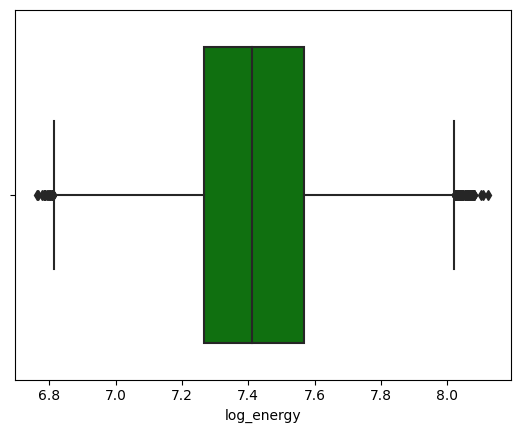

In [26]:
sns.boxplot(x= df["log_energy"], color="green")

In [27]:
#Fuction to extract some features out of datetime feature

In [28]:
def create_features(df, label=None):
    df['exact_date'] = df['datetime'].dt.date
    df['hour'] = df['datetime'].dt.hour
    df['dayofweek'] = df['datetime'].dt.dayofweek
    df['quarter'] = df['datetime'].dt.quarter
    df['month'] = df['datetime'].dt.month
    df['year'] = df['datetime'].dt.year
    df['dayofyear'] = df['datetime'].dt.dayofyear
    df['dayofmonth'] = df['datetime'].dt.day
    df['weekofyear'] = df['datetime'].dt.weekofyear
    
    X = df[["datetime",'hour','dayofweek','month','year',
    'dayofyear','dayofmonth','weekofyear',label]]
    return X

df = create_features(df, label='log_energy')

C:\Users\VETERAN\AppData\Local\Temp\ipykernel_6652\81297204.py:10: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['datetime'].dt.weekofyear


In [29]:
display(df)

,datetime,hour,dayofweek,month,year,dayofyear,dayofmonth,weekofyear,log_energy
0,2008-03-01 00:00:00,0,5,3,2008,61,1,9,7.138856
1,2008-03-01 01:00:00,1,5,3,2008,61,1,9,6.999004
2,2008-03-01 02:00:00,2,5,3,2008,61,1,9,6.962478
3,2008-03-01 03:00:00,3,5,3,2008,61,1,9,6.941907
4,2008-03-01 04:00:00,4,5,3,2008,61,1,9,6.933749
...,...,...,...,...,...,...,...,...,...
94987,2018-12-31 19:00:00,19,0,12,2018,365,31,1,7.835360
94988,2018-12-31 20:00:00,20,0,12,2018,365,31,1,7.808682
94989,2018-12-31 21:00:00,21,0,12,2018,365,31,1,7.768954
94990,2018-12-31 22:00:00,22,0,12,2018,365,31,1,7.759163


In [67]:
# # Create an instance of One-hot-encoder to remove priorities from date time features
# encoder = OneHotEncoder(drop = "first")

# encoder_df = pd.DataFrame(encoder.fit_transform(df[['hour','dayofweek','month','year','dayofyear','dayofmonth','weekofyear']]).toarray())
# encoder_df2 = pd.DataFrame(encoder.fit_transform(df2[['hour','dayofweek','month','year','dayofyear','dayofmonth','weekofyear']]).toarray())


In [68]:
# display(encoder_df)

In [69]:
# display(encoder_df2)

In [70]:
# df=df.join(encoder_df)
# display(df)

In [71]:
# df2=df2.join(encoder_df2)
# display(df2)

In [30]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [31]:
#Split date is taken according 75% of total training data to be train data and rest to be test data to check the accuracy of algorithm
split_date = datetime(2016, 4, 16, 11, 0, 0)
data_train = df.loc[df["datetime"] <= split_date].copy()
data_test = df.loc[df["datetime"] > split_date].copy()

X_train, y_train = data_train,data_train['log_energy']
X_test, y_test = data_test,data_test['log_energy']

X_train.drop(["datetime","log_energy"], axis=1, inplace=True)
X_test.drop(["datetime","log_energy"], axis=1, inplace=True)

In [75]:
display(X_train)

,hour,dayofweek,month,year,dayofyear,dayofmonth,weekofyear
0,0,5,3,2008,61,1,9
1,1,5,3,2008,61,1,9
2,2,5,3,2008,61,1,9
3,3,5,3,2008,61,1,9
4,4,5,3,2008,61,1,9
...,...,...,...,...,...,...,...
71239,7,5,4,2016,107,16,15
71240,8,5,4,2016,107,16,15
71241,9,5,4,2016,107,16,15
71242,10,5,4,2016,107,16,15


In [32]:
# Initiating the regressor
regressor =xgb.XGBRegressor()
tscv = TimeSeriesSplit(n_splits = 5)

#parameter grid tuning for xgboost
params={
"learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ],
"max_depth"        : [ 3, 4, 5, 6, 8, 10],
"min_child_weight" : [ 1, 3, 5, 7,9 ],
"gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4,0.5, 1, 1.5, 2, 5 ],
"colsample_bytree" : [ 0.3, 0.4, 0.5 ,0.6, 0.7,0.8],
"n_estimators"     : [100]        
}

# Using time series cross validation technique
tscv = TimeSeriesSplit(n_splits=5)

# randomized search cv is used for hyperparameter tuning

random_search = RandomizedSearchCV(
        estimator= regressor,
        param_distributions=params, 
        n_iter = 5, 
        scoring='neg_root_mean_squared_error', 
        n_jobs=-1,
        cv=tscv, 
        verbose=3)

#timer Function to see the time the algorithm takes

def timer(start_time=None):
        if not start_time:
                start_time = datetime.now()
                return start_time
        elif start_time:
                thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
                tmin, tsec = divmod(temp_sec, 60)
                print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))


from datetime import datetime
# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(X_train,y_train)
timer(start_time) # timing ends here for "start_time" variable
print("===================================================================================================")

print(random_search.best_estimator_)
print("===================================================================================================")

print(random_search.best_params_)
print("===================================================================================================")

def evaluate(model, test_features, test_labels):
        predictions = model.predict(test_features)
        data_test['log_energy_Prediction'] = predictions
        errors = abs(predictions - test_labels)
        mape = 100 * np.mean(errors / test_labels)
        accuracy = 100 - mape
        print("Accuracy(100 - mape) is :- ",accuracy)
        print("MAPE is :- ", mape)
        print('Model Performance')
        MSE = mean_squared_error(test_labels,predictions)
        print("Mean Squared Error is:- ", MSE)
        print("MAE:-",mean_absolute_error(test_labels,predictions))
        RMSE_n =np.sqrt(mean_squared_error(test_labels,predictions))
        print("RMSE is :- ", RMSE_n)
        print("============================================================================================")
        return accuracy

print("Results of using random search cv")   
best_random = random_search.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

Fitting 5 folds for each of 5 candidates, totalling 25 fits

 Time taken: 0 hours 0 minutes and 39.33 seconds.
XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.3,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.15, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=5, max_leaves=0, min_child_weight=5, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)
{'n_estimators': 100, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.15, 'gamma': 0.0, 'colsample_bytree': 0.3}
Results of using random search cv
Accuracy(100 - mape) is :-  98.

In [ ]:
#RMSE is coming out to be 0.11. Rest of the metrics can also be seen from above

In [33]:
PATH_PREDICTION = r"C:\Users\VETERAN\Downloads\test_WudNWDM.csv"

In [34]:
#Now we will do the prediction of test data after model is doing good on training data

In [35]:
df2 = pd.read_csv(PATH_PREDICTION, parse_dates = ['datetime'])
print(df2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26304 entries, 0 to 26303
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   row_id    26304 non-null  int64         
 1   datetime  26304 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 411.1 KB
None


In [40]:
df2_new = df2[["row_id","datetime"]]
df2 = df2[["datetime"]]
df2["log_energy"] = 1
display(df2)

KeyError: "None of [Index(['row_id', 'datetime'], dtype='object')] are in the [columns]"

In [37]:
df2 = create_features(df2, label='log_energy')

C:\Users\VETERAN\AppData\Local\Temp\ipykernel_6652\81297204.py:10: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['datetime'].dt.weekofyear


In [38]:
display(df2)

,datetime,hour,dayofweek,month,year,dayofyear,dayofmonth,weekofyear,log_energy
0,2019-01-01 00:00:00,0,1,1,2019,1,1,1,1
1,2019-01-01 01:00:00,1,1,1,2019,1,1,1,1
2,2019-01-01 02:00:00,2,1,1,2019,1,1,1,1
3,2019-01-01 03:00:00,3,1,1,2019,1,1,1,1
4,2019-01-01 04:00:00,4,1,1,2019,1,1,1,1
...,...,...,...,...,...,...,...,...,...
26299,2021-12-31 19:00:00,19,4,12,2021,365,31,52,1
26300,2021-12-31 20:00:00,20,4,12,2021,365,31,52,1
26301,2021-12-31 21:00:00,21,4,12,2021,365,31,52,1
26302,2021-12-31 22:00:00,22,4,12,2021,365,31,52,1


In [39]:
df2 = df2[["hour","dayofweek","month","year","dayofyear","dayofmonth","weekofyear"]]

In [32]:
display(df2)

,hour,dayofweek,month,year,dayofyear,dayofmonth,weekofyear
0,0,1,1,2019,1,1,1
1,1,1,1,2019,1,1,1
2,2,1,1,2019,1,1,1
3,3,1,1,2019,1,1,1
4,4,1,1,2019,1,1,1
...,...,...,...,...,...,...,...
26299,19,4,12,2021,365,31,52
26300,20,4,12,2021,365,31,52
26301,21,4,12,2021,365,31,52
26302,22,4,12,2021,365,31,52


In [ ]:
predictions_2 = best_random.predict(df2)
df2['log_energy_Prediction'] = predictions_2

In [ ]:
display(df2)

In [35]:
df2["energy_prediction"] = np.exp(df2["log_energy_Prediction"])
df2=df2.join(df2_new)
display(df2)

,hour,dayofweek,month,year,dayofyear,dayofmonth,weekofyear,log_energy_Prediction,energy_prediction,row_id,datetime
0,0,1,1,2019,1,1,1,7.480678,1773.442017,94993,2019-01-01 00:00:00
1,1,1,1,2019,1,1,1,7.437488,1698.478394,94994,2019-01-01 01:00:00
2,2,1,1,2019,1,1,1,7.374554,1594.879883,94995,2019-01-01 02:00:00
3,3,1,1,2019,1,1,1,7.367435,1583.566650,94996,2019-01-01 03:00:00
4,4,1,1,2019,1,1,1,7.353566,1561.756104,94997,2019-01-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...
26299,19,4,12,2021,365,31,52,7.857957,2586.232178,121292,2021-12-31 19:00:00
26300,20,4,12,2021,365,31,52,7.839907,2539.968994,121293,2021-12-31 20:00:00
26301,21,4,12,2021,365,31,52,7.822085,2495.102051,121294,2021-12-31 21:00:00
26302,22,4,12,2021,365,31,52,7.815495,2478.713623,121295,2021-12-31 22:00:00


In [ ]:
df2 = df2[["row_id","datetime","energy_prediction"]]

In [41]:
display(df2)

,hour,dayofweek,month,year,dayofyear,dayofmonth,weekofyear
0,0,1,1,2019,1,1,1
1,1,1,1,2019,1,1,1
2,2,1,1,2019,1,1,1
3,3,1,1,2019,1,1,1
4,4,1,1,2019,1,1,1
...,...,...,...,...,...,...,...
26299,19,4,12,2021,365,31,52
26300,20,4,12,2021,365,31,52
26301,21,4,12,2021,365,31,52
26302,22,4,12,2021,365,31,52


In [42]:
# Hence predicted data we will save

In [44]:
df2.to_csv(r"C:\Users\VETERAN\OneDrive\Desktop\Test_jupyter\Energy_Prediction", index=False)